## Improved Single Match xG Infographic

In [1]:
#import libraries
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from highlight_text import ax_text, fig_text

import probability_functions as pf

#### Load data

In [2]:
#load data
comp = 'gw32'
df = pd.read_csv(f'../../data/understat/liverpool/{comp}.csv')

#### Data preperation

In [3]:
#find team names from dataframe (will only work as long as both teams took a shot)
home_team = df['team'].iloc[0]
away_team = df['team'].iloc[-1]

#create dataframe for each team
df_home = df[df['team'] == home_team].reset_index(drop=True)
df_away = df[df['team'] == away_team].reset_index(drop=True)

#create cumulative xG column
df_home['cum_xG'] = df_home['xG'].cumsum()
df_away['cum_xG'] = df_away['xG'].cumsum()

In [4]:
# Convert to lists
#home_min = list(df_home['minute'])
#away_min = list(df_away['minute'])

#home_cum_xG = list(df_home['cum_xG'])
#away_cum_xG = list(df_away['cum_xG'])

Create dataframe with minutes

In [5]:
df_minutes = pd.DataFrame({'minute': range(0, df['minute'].max()+1, 1)})

In [6]:
#merge with dataframes
df_home_final = df_minutes.merge(df_home,
                                 on='minute', how='left')[['minute', 'cum_xG']]
df_home_final.fillna(method='ffill', inplace=True)
df_home_final.fillna(0, inplace=True)
df_home_final = df_home_final.merge(df_home, on='minute', how='left')[['minute', 'cum_xG_x', 'result']]

df_away_final = df_minutes.merge(df_away,
                                 on='minute', how='left')[['minute', 'cum_xG']]
df_away_final.fillna(method='ffill', inplace=True)
df_away_final.fillna(0, inplace=True)
df_away_final = df_away_final.merge(df_away, on='minute', how='left')[['minute', 'cum_xG_x', 'result']]

In [7]:
#group by minutes to make dataframes the same length
df_home_final1 = df_home_final.groupby(['minute'])[['cum_xG_x']].max().reset_index()
df_away_final1 = df_away_final.groupby(['minute'])[['cum_xG_x']].max().reset_index()

df_home_final1 = df_home_final1.fillna(method='ffill')
df_away_final1 = df_away_final1.fillna(method='ffill')

In [8]:
home_min_final = np.array(df_home_final1['minute'])
away_min_final = np.array(df_away_final1['minute'])

home_cum_xG_final = np.array(df_home_final1['cum_xG_x'])
away_cum_xG_final = np.array(df_away_final1['cum_xG_x'])

home_min_final = list(home_min_final)
away_min_final = list(away_min_final)

home_cum_xG_final = list(home_cum_xG_final)
away_cum_xG_final = list(away_cum_xG_final)

#### Calculate scoreline probabilities

In [57]:
#find total xG
home_total_xG = round(home_cum_xG_final[-1], 2)
away_total_xG = round(away_cum_xG_final[-1], 2)

# Get probability of all scorelines from 0-0 to 9-9
home_goal_probs, away_goal_probs, scoreline_probs = pf.score_probability(home_total_xG, away_total_xG, num_goals=10)

Visualize goal probabilities

In [62]:
# Create xs and ys for bar plots 
home_xs, home_ys = zip(*home_goal_probs)
away_xs, away_ys = zip(*away_goal_probs)

# Get number of goals for each team
home_goals = len(df_home[df_home['result'] == 'Goal'])
away_goals = len(df_away[df_away['result'] == 'Goal'])

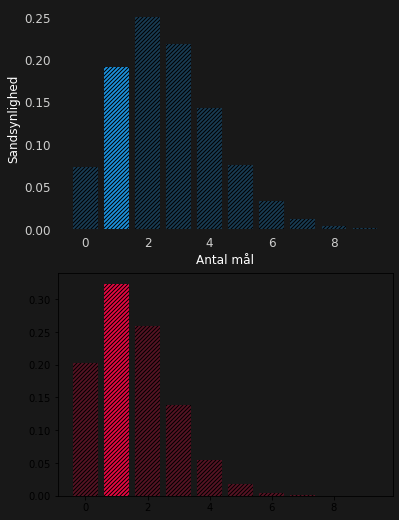

In [79]:
lightblue = '#1d91dc'
red = '#e80942'
yellow = '#f7a119'
green = '#16C79A'
turq = '#00e8dc'
text_color= '#CECECD'

facecolor = '#181818'
home_color = lightblue
away_color = red

fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize = (6,9))
fig.set_facecolor(facecolor)
ax1.set_facecolor(facecolor)
ax2.set_facecolor(facecolor)


# ---------- ax1 -------------- #
ax1.bar(home_xs, home_ys,
        color=home_color, zorder=10, hatch=3*'//', alpha=0.3)
for i in home_xs:
    if i == home_goals:
        ax1.bar(i, home_ys[i],
        color=home_color, zorder=10, hatch=3*'//', alpha=1)
#set up our base layer
ax1.tick_params(axis='x', colors=text_color, labelsize=12)
ax1.tick_params(axis='y', colors=text_color, labelsize=12)

# Set grid, ticks and frame
#ax1.grid(axis='y', color='w', linestyle='--', zorder=1, alpha=0.5)
ax1.tick_params(axis='both', which='both', left=False, bottom=False)
ax1.set_frame_on(False)

# Set labels and text
ax1.set_xlabel('Antal mål',
               color='w', size=12)
ax1.set_ylabel('Sandsynlighed',
               color='w', size=12)


# ---------- ax2 -------------- #
ax2.bar(away_xs, away_ys,
        color=away_color, zorder=10, hatch=3*'//', alpha=0.3)
for i in away_xs:
    if i == away_goals:
        ax2.bar(i, away_ys[i],
        color=away_color, zorder=10, hatch=3*'//', alpha=1)



plt.show()

Visualize scoreline probabilities

#### Calculate win, loss and draw probabilities

In [10]:
home_prob, away_prob, draw_prob = pf.win_loss_draw_probs(scoreline_probs)

# Concat into list
home_away_draw_probs = pd.DataFrame({'outcomes': ['home', 'away', 'draw'], 'probs': [home_prob, away_prob, draw_prob]})

Visualize win, loss, draw probabilities

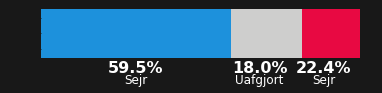

In [26]:
lightblue = '#1d91dc'
red = '#e80942'
yellow = '#f7a119'
green = '#16C79A'
turq = '#00e8dc'
text_color= '#CECECD'

facecolor = '#181818'
home_color = lightblue
away_color = red

fig, ax = plt.subplots(figsize = (6,1))
fig.set_facecolor(facecolor)
ax.set_facecolor(facecolor)

#set up our base layer
ax.tick_params(axis='x', colors=facecolor, labelsize=12)
ax.tick_params(axis='y', colors=facecolor, labelsize=12)

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["bottom"].set_visible(False)
ax.spines["left"].set_visible(False)

# Plot bars
home = ax.barh(0.5, home_away_draw_probs['probs'][0], color=home_color)
draw = ax.barh(0.5, home_away_draw_probs['probs'][1],
               left=home_away_draw_probs['probs'][0], color=text_color)
away = ax.barh(0.5, home_away_draw_probs['probs'][2],
               left=home_away_draw_probs['probs'][0]+home_away_draw_probs['probs'][1], color=away_color)

# Set texts
# Home
ax.text(x=home_prob/2, y=-0.12, s=f'{round(home_prob*100, 1)}%',
        color='w', ha='center', size=16, fontweight='bold')
ax.text(x=home_prob/2, y=-0.3, s=f'Sejr',
        color='w', ha='center', size=12)
# Draw
ax.text(x=home_prob+draw_prob/2, y=-0.12, s=f'{round(draw_prob*100, 1)}%',
        color='w', ha='center', size=16, fontweight='bold')
ax.text(x=home_prob+draw_prob/2, y=-0.3, s=f'Uafgjort',
        color='w', ha='center', size=12)
# Away
ax.text(x=home_prob+draw_prob+away_prob/2, y=-0.12, s=f'{round(away_prob*100, 1)}%',
        color='w', ha='center', size=16, fontweight='bold')
ax.text(x=home_prob+draw_prob+away_prob/2, y=-0.3, s=f'Sejr',
        color='w', ha='center', size=12)

#plt.savefig('output/win_probability_viz.png',
#            dpi=600, bbox_inches='tight')

plt.show()

#### Regular xG Race Chart

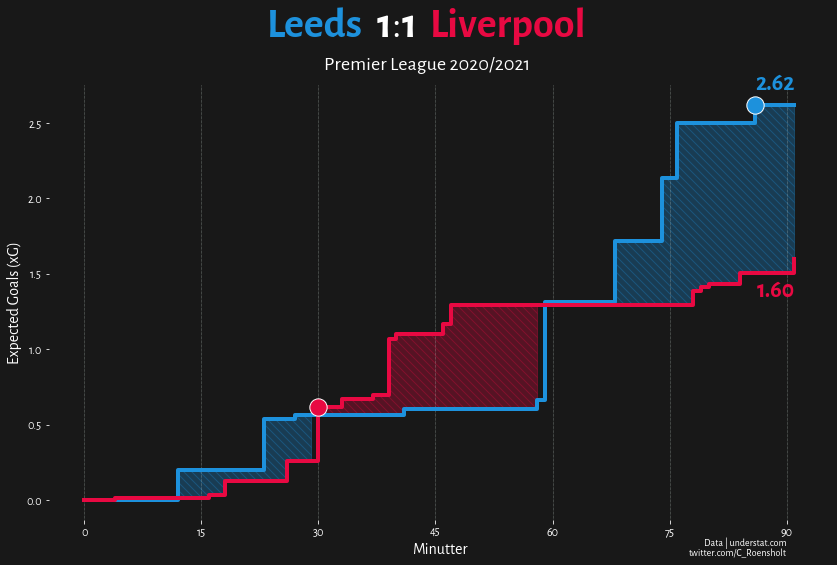

In [15]:
mpl.rcParams['font.family'] = 'Alegreya Sans'

lightblue = '#1d91dc'
red = '#e80942'
yellow = '#f7a119'
green = '#16C79A'
turq = '#00e8dc'
text_color= '#CECECD'

facecolor = '#181818'
home_color = lightblue
away_color = red

fig, ax = plt.subplots(figsize = (14,8))
fig.set_facecolor(facecolor)
ax.set_facecolor(facecolor)

#set up our base layer
ax.tick_params(axis='x', colors='white', labelsize=12)
ax.tick_params(axis='y', colors='white', labelsize=12)

#set grid
ax.grid(ls='dotted', lw=.5, color='#c7d5cc', axis='x', zorder=1)
spines = ['top','bottom','left','right']
for x in spines:
    if x in spines:
        ax.spines[x].set_visible(False)
plt.xticks([0,15,30,45,60,75,90, 105])


#plot the step graphs
ax.plot(home_min_final, home_cum_xG_final, drawstyle='steps-post',
        color=home_color, label=f'{home_team}', linewidth=4)
ax.plot(away_min_final, away_cum_xG_final, drawstyle='steps-post',
        color=away_color, label=f'{away_team}', linewidth=4)

#fill below line plot
#minutes = list(sorted(np.concatenate([home_min, away_min])))
home_where = (np.array(home_cum_xG_final) > np.array(away_cum_xG_final))
ax.fill_between(home_min_final, home_cum_xG_final, away_cum_xG_final, step='post', 
                where=home_where, #interpolate=True,
                color=home_color, alpha=0.3, hatch=3*'\\')
away_where = (np.array(home_cum_xG_final) < np.array(away_cum_xG_final))
ax.fill_between(home_min_final, home_cum_xG_final, away_cum_xG_final, step='post', 
                where=away_where, #interpolate=True,
                color=away_color, alpha=0.3, hatch=3*'\\')


#plot home goals
for i in range(len(df_home_final)):
    if df_home_final['result'][i] == 'Goal':
        plt.scatter(df_home_final['minute'][i], df_home_final['cum_xG_x'][i], 
                    s=300, zorder=10, facecolor=home_color, edgecolor='white', label='Mål')
for i in range(len(df_away_final)):
    if df_away_final['result'][i] == 'OwnGoal':
        plt.scatter(df_away_final['minute'][i], df_home_final1['cum_xG_x'][i], 
                    s=300, zorder=10, facecolor=home_color, edgecolor='white', label='Mål')

#plot away goals
for i in range(len(df_away_final)):
    if df_away_final['result'][i] == 'Goal':
        plt.scatter(df_away_final['minute'][i], df_away_final['cum_xG_x'][i], 
                    s=300, zorder=10, facecolor=away_color, edgecolor='white', label='Mål')
for i in range(len(df_home_final)):
    if df_home_final['result'][i] == 'OwnGoal':
        plt.scatter(df_home_final['minute'][i], df_away_final1['cum_xG_x'][i], 
                    s=300, zorder=10, facecolor=away_color, edgecolor='white', label='Mål')

#set title and text
home_goals = len(df_home[df_home['result'] == 'Goal'])
home_goals += len(df_away[df_away['result'] == 'OwnGoal'])
away_goals = len(df_away[(df_away['result'] == 'Goal')])
away_goals += len(df_home[df_home['result'] == 'OwnGoal'])


#fig.suptitle(f'{home_team}  {home_goals}:{away_goals}  {away_team}', 
#            fontsize=28, color='white')

fig_text(x=0.5, y=0.95, s = f'<{home_team}>  <{home_goals}>:<{away_goals}>  <{away_team}>', 
         fontsize=42, color='white', ha='center', highlight_colors=[home_color, 'w', 'w', away_color],
         highlight_weights='bold')
fig_text(x=0.5, y=0.9, s = f'Premier League 2020/2021', 
         fontsize=20, color='white', ha='center', highlight_colors=['w'], highlight_weights='bold')


#add home team total xG
ax.text(home_min_final[-1], home_cum_xG_final[-1]+0.1, s='{:.2f}'.format(home_total_xG),
        color=home_color, fontsize=24, fontweight='bold', ha='right')
ax.text(away_min_final[-1], away_cum_xG_final[-1]-0.25, s='{:.2f}'.format(away_total_xG),
        color=away_color, fontsize=24, fontweight='bold', ha='right')

ax.text(90, -0.3, s='Data | understat.com', ha='right',
        fontsize=10, fontstyle='normal', color='white')
ax.text(90, -0.37, s='twitter.com/C_Roensholt', fontsize=10, fontstyle='normal', color='white', ha='right')



ax.set_xlabel('Minutter', color='white', fontsize=16)
ax.set_ylabel('Expected Goals (xG)', color='white', fontsize=16)

#plt.savefig(f'output/{home_team}_vs_{away_team}_xG_Infographic_{comp}.png', dpi=600, 
#            bbox_inches='tight', facecolor=facecolor, edgecolor='none')

plt.show()

#### The improved match xG Infographic